In this notebook, we take a look at response-time-related variables, such as mouse- and eye-response initation times, and difference between those, termed initial decision (ID) lag.

# Table of Contents
1. [Preparing the data and plots](#preparing)
2. [Mouse initiation time](#mouse_IT)
    * [Correct vs error trials](#mouse_IT_correct_error)
    * [CoM vs non-CoM trials](#mouse_IT_CoM)
3. [Eye initiation time](#eye_IT)
    * [Correct vs error trials](#eye_IT_correct_error)
    * [CoM vs non-CoM trials](#eye_IT_CoM)
4. [Hand-eye lag at initial decision](#ID_lag)
5. [Negative initiation times](#negative)

<a name="preparing"></a>
# Preparing data and plots
First, we set up visuals and read the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

# despine plots by default
plt.rc("axes.spines", top=False, right=False)

#set font sizes for figures throughout
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=16)

# color palette for sequential data
palette_sqn = 'viridis_r'

# color palette for participant IDs
palette_subj = 'magma_r'

palette = sns.color_palette()
scale = 1.0

In [2]:
import data_reader
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'exp_1', 'exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_2), stim_viewing=True)

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices_1 = choices_1.reset_index()
choices_2 = choices_2.reset_index()

# for initiation time analysis, we exclude trials with mouse_IT > 1.5 sec
choices_1 = choices_1[(choices_1.mouse_IT<1.5) & (choices_1.eye_IT<1.5)]
choices_2 = choices_2[(choices_2.mouse_IT<1.5) & (choices_2.eye_IT<1.5)]

Next we have a function which will plot individual- and group-level mean values of initiation-time-related variables for each coherence level.

In [3]:
import matplotlib.lines as mlines

def plot_var_vs_coherence(choices, exp, var, estimator=np.mean): 
    subj_order = sorted(choices.subj_id.unique())
    
    plt.figure()
    
    ax = sns.pointplot(data=choices[(choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, scale=scale, errwidth=0.5, alpha=0.7,
                       join=False, dodge=True, capsize=.2, hue_order=subj_order,
                       estimator=estimator)
    
    ax = sns.pointplot(data=choices[(~choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, linestyles=['--', '--', '--', '--'], 
                       markers=['x', 'x', 'x', 'x'], scale=scale,
                       errwidth=0.5, dodge=True, capsize=.2, join=False, 
                       hue_order=subj_order, estimator=estimator, ax=ax)

    ax = sns.pointplot(data=choices[(choices.coherence>0) & (~choices.is_correct)], 
                       x='coherence', y=var, linestyles=['--'], color='grey',
                       markers=['x'], scale=scale, errwidth=0.5, estimator=estimator, ax=ax)
    
    ax = sns.pointplot(data=choices[(choices.coherence>0) & (choices.is_correct)],
                       x='coherence', y=var, linestyles=['-'], color='grey', 
                       scale=scale, errwidth=0.5, estimator=estimator, ax=ax)


#     ax.set_ylim([0, 1.2])      
    ax.set_xlabel('Coherence')
    ax.set_ylabel(var)
    
    ax.legend_.remove()
    correct_line = mlines.Line2D([], [], color='grey', marker='o', lw=3.0, label='Correct trials')
    error_line = mlines.Line2D([], [], color='grey', marker='x', ls='--', lw=3.0, label='Error trials')
    plt.legend(handles=[correct_line, error_line])
    plt.title(exp)
    plt.tight_layout()
    plt.savefig('figures/%s_vs_coherence_ind_%s' % (var, exp), bbox_inches='tight')

<a name="mouse_IT"></a>
# Mouse initation time

First, we plot IT distributions for both experiments. Note that IT for both mouse and eye can be negative, as premature responses during stimulus presentations are factored in during pre-processing.

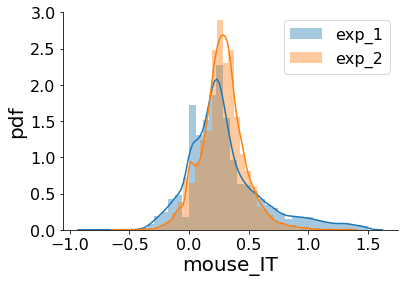

In [4]:
ax = sns.distplot(choices_1.mouse_IT, bins=40, label=exp_1)
sns.distplot(choices_2.mouse_IT, bins=40, label=exp_2, ax=ax)
ax.set_ylabel('pdf')
# ax.set_xlim(-0.5, 3)
ax.set_ylim(0, 3)
plt.legend()
plt.savefig('figures/mouse_IT', bbox_inches='tight')

In Exp 2, the distibution is narrower, indicating that our manipulation (penalties for premature and late responses) works.

Now, let's look at mouse initation times for each coherence level

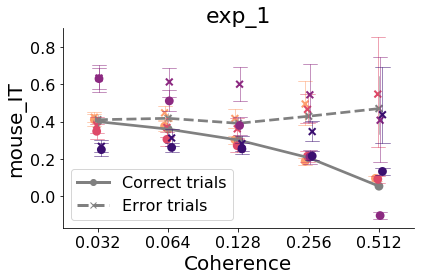

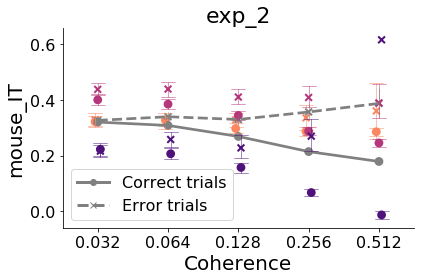

In [5]:
plot_var_vs_coherence(choices_1, exp_1, var='mouse_IT')
plot_var_vs_coherence(choices_2, exp_2, var='mouse_IT')

Pretty much what we expect: for all subjects (except for one subject in Exp 1), mouse IT decreases with coherence for correct trials, and remains more-less constant or even increases for error trials __(the 'V-pattern')__. Notably, the V-pattern is way less pronounced in purple participant in Exp 2.

Z-scores highlight the same pattern:

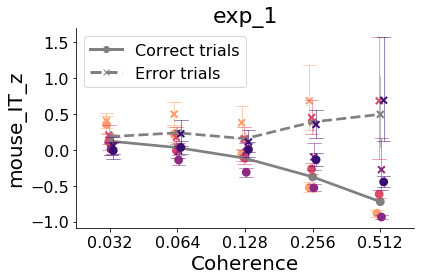

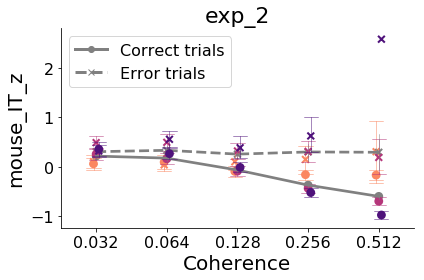

In [6]:
plot_var_vs_coherence(choices_1, exp_1, var='mouse_IT_z')
plot_var_vs_coherence(choices_2, exp_2, var='mouse_IT_z')

These plotting functions are used for the mouse and eye IT data analyses below

In [7]:
def plot_var_grid_individual(choices, exp, var, col='is_com', hue='is_correct', estimator=np.mean):
    ax = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, 
                        col=col, row='subj_id', hue=hue, capsize=.2, errwidth=0.5, estimator=estimator)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(exp, fontsize=30)
    plt.savefig('figures/%s_vs_coherence_grid_by_%s_ind_%s' % (var, hue, exp))

def plot_var_grid(choices, exp, var, col='is_com', hue='is_correct', estimator=np.mean):
    fig = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, 
                   col=col, hue=hue, capsize=.2, errwidth=0.5, ylim=(-1, 1), estimator=estimator)
    fig.set_xticklabels(rotation=30)
#     fig.set_ylim((-1.2, 1.2))
    fig.set(ylim=(-1.8, 1.8))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(exp, fontsize=30)
    plt.savefig('figures/%s_vs_coherence_grid_by_%s_%s' % (var, hue, exp), bbox_inches='tight')

<a name="mouse_IT_correct_error"></a>
## Initiation time in correct vs error trials

Taking into account individual differences in initiation times, it is useful to account for those when looking into initiation times for CoM and non-CoM trials. Here we have to look at z-scored initiation times though, to get general patterns.

After we accounted for magnitude of within-individual initiation times, we can see how relative magnitude of initiation time changes with coherence in non-CoM and CoM trials:

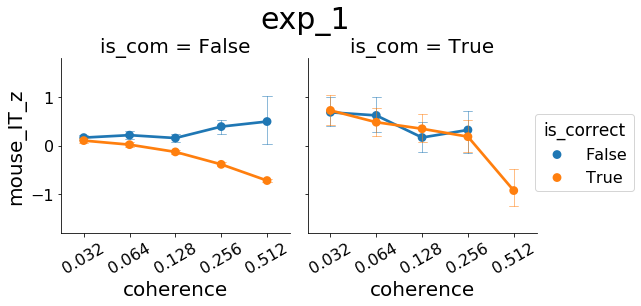

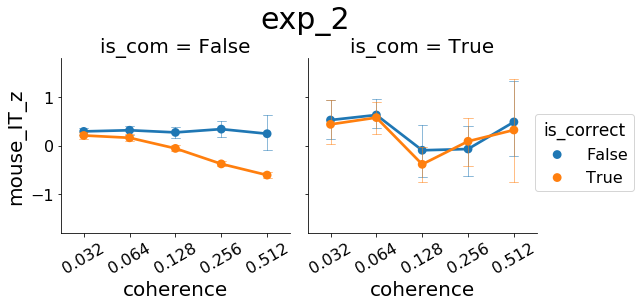

In [8]:
plot_var_grid(choices_1, exp_1, var='mouse_IT_z', col='is_com', hue='is_correct')
plot_var_grid(choices_2, exp_2, var='mouse_IT_z', col='is_com', hue='is_correct')

Surprisingly, in CoM trials participants exhibit identical relative initiation times in correct and error trials! This was observed in both experiments. In individual patterns it's harder to see this though.

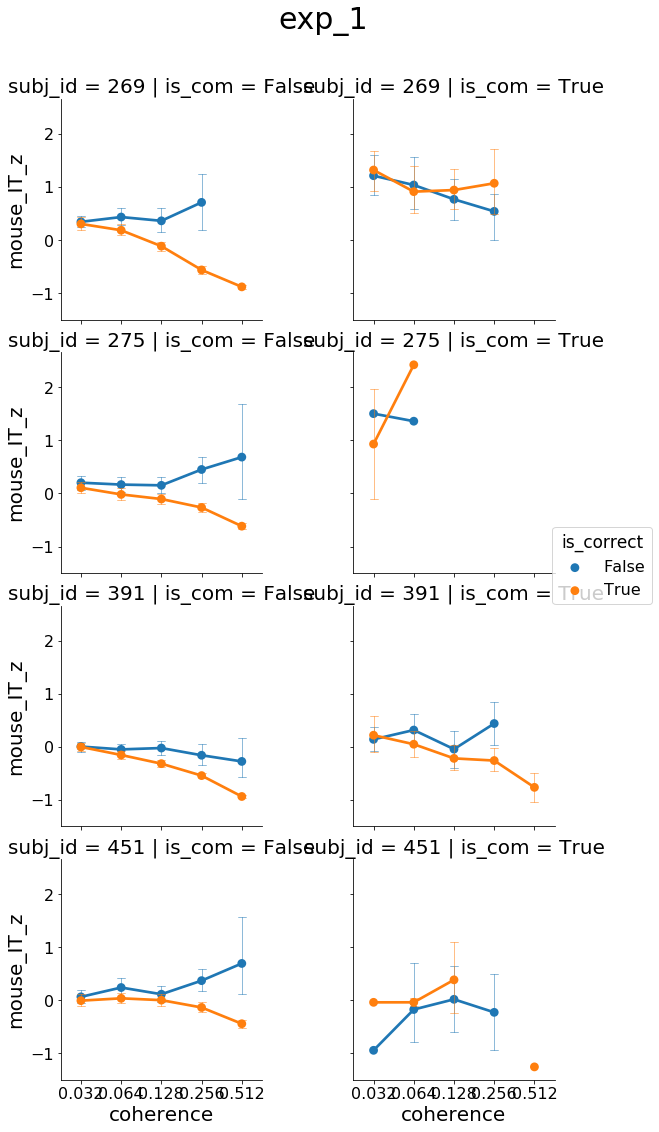

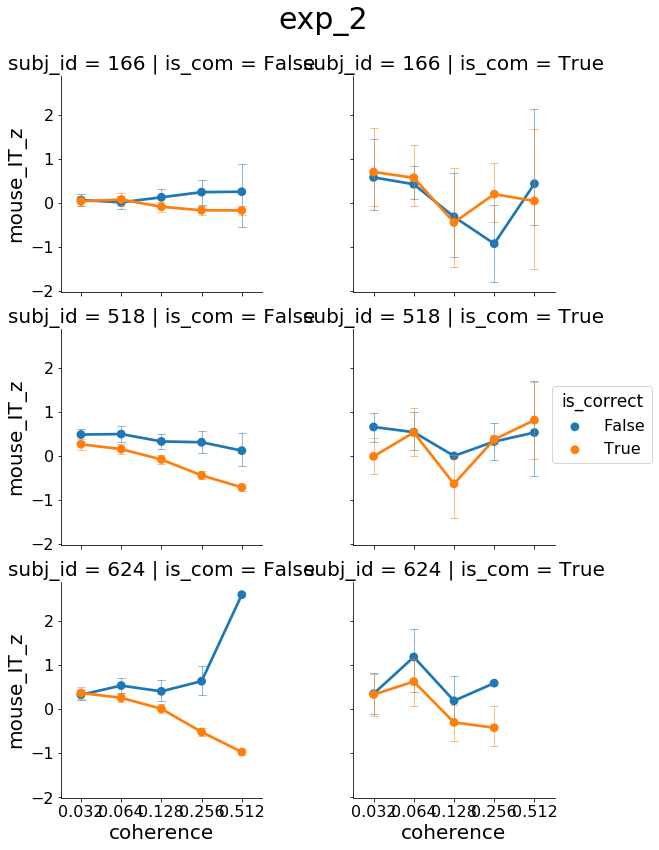

In [9]:
plot_var_grid_individual(choices_1, exp_1, var='mouse_IT_z', col='is_com', hue='is_correct')
plot_var_grid_individual(choices_2, exp_2, var='mouse_IT_z', col='is_com', hue='is_correct')

<a name="mouse_IT_CoM"></a>
## Initiation time in CoM vs non-CoM trials

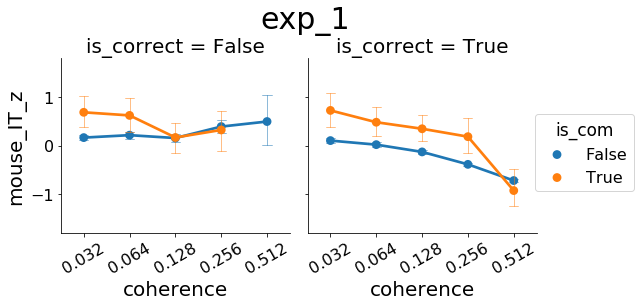

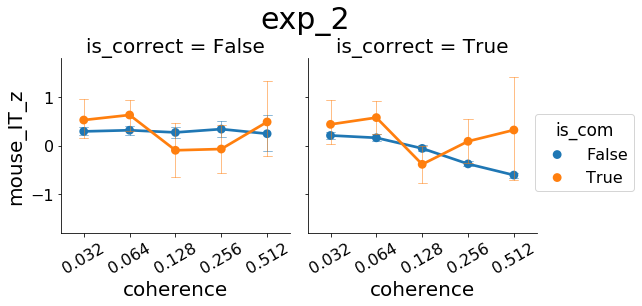

In [10]:
plot_var_grid(choices_1, exp_1, var='mouse_IT_z', col='is_correct', hue='is_com')
plot_var_grid(choices_2, exp_2, var='mouse_IT_z', col='is_correct', hue='is_com')

In Exp 1, correct initation times are reliably longer than those in error trials. This effect diminishes in Exp 2 though.

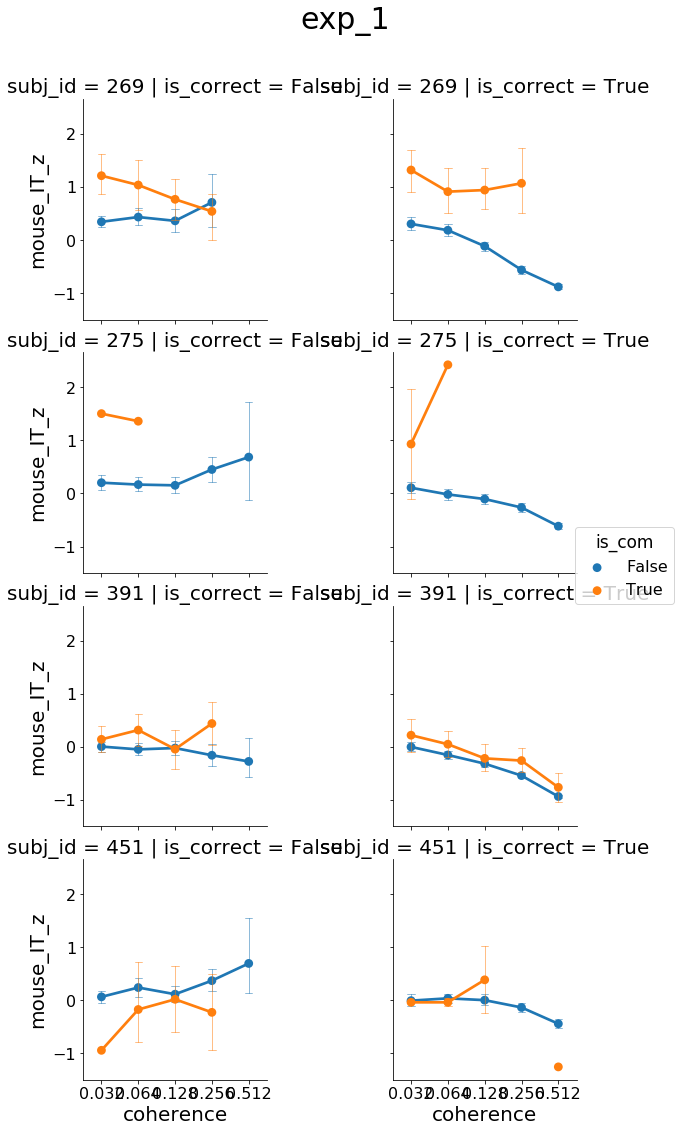

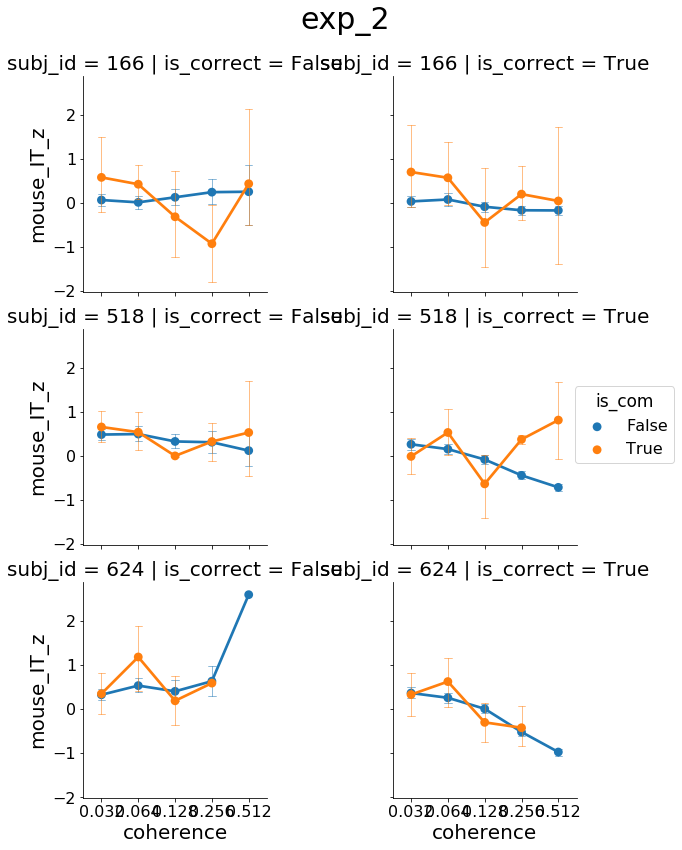

In [11]:
plot_var_grid_individual(choices_1, exp_1, var='mouse_IT_z', col='is_correct', hue='is_com')
plot_var_grid_individual(choices_2, exp_2, var='mouse_IT_z', col='is_correct', hue='is_com')

<a name="eye_IT"></a>
# Eye initation time

Next, we look at eye latency (termed eye initiation time for consistency)

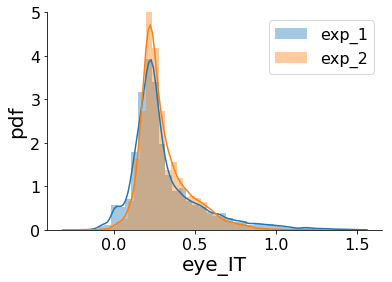

In [12]:
ax = sns.distplot(choices_1.eye_IT[~np.isnan(choices_1.eye_IT)], bins=40, label=exp_1)
sns.distplot(choices_2.eye_IT[~np.isnan(choices_2.eye_IT)], bins=40, label=exp_2, ax=ax)
ax.set_ylabel('pdf')
# ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, 5)
plt.legend()
plt.savefig('figures/eye_IT', bbox_inches='tight')

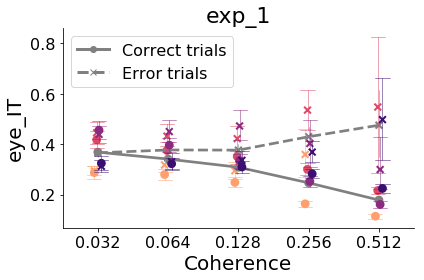

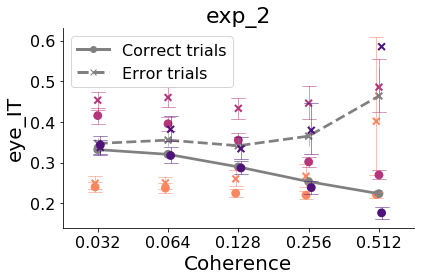

In [13]:
plot_var_vs_coherence(choices_1, exp_1, var='eye_IT', estimator=np.nanmean)
plot_var_vs_coherence(choices_2, exp_2, var='eye_IT', estimator=np.nanmean)

The overall pattern is very similar to mouse IT. In Exp 1, there are basically no individual differences. In Exp 2, one participant had very low eye IT for all coherence level and correct/error trials, but the < pattern still seems to be there.

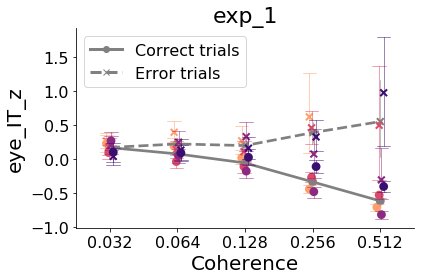

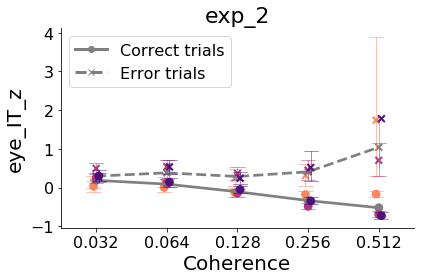

In [14]:
plot_var_vs_coherence(choices_1, exp_1, var='eye_IT_z', estimator=np.nanmean)
plot_var_vs_coherence(choices_2, exp_2, var='eye_IT_z', estimator=np.nanmean)

<a name="eye_IT_correct_error"></a>
## Initiation time in correct vs error trials

Based on differences in correct/error mouse_IT pattern between CoM and non-CoM trials, one would expect similar difference in eye initiation times as well (given that in general, eye IT follows the same '<' pattern). Let's see if this is actually the case:

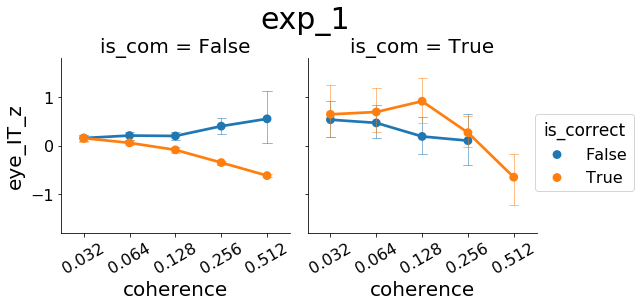

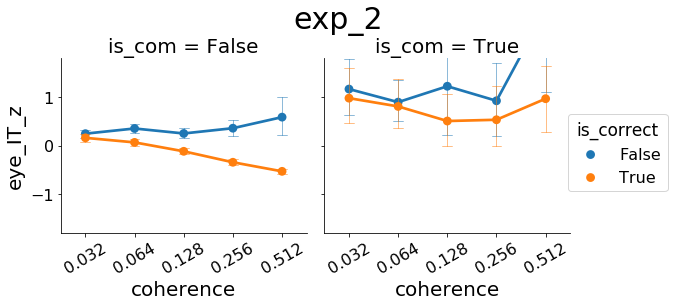

In [15]:
plot_var_grid(choices_1, exp_1, var='eye_IT_z', col='is_com', hue='is_correct')
plot_var_grid(choices_2, exp_2, var='eye_IT_z', col='is_com', hue='is_correct')

It turns out that we can actually see the difference between correct and error CoM trials in eye initiation times! But we have just seen that this is not the case in mouse IT... Why is that so?

Strangely, though, in Exp 1 correct CoM's had slower eye initiation than error CoM, but this was reversed in Exp 2. Is it due to experimental manipulation or individual differences? 

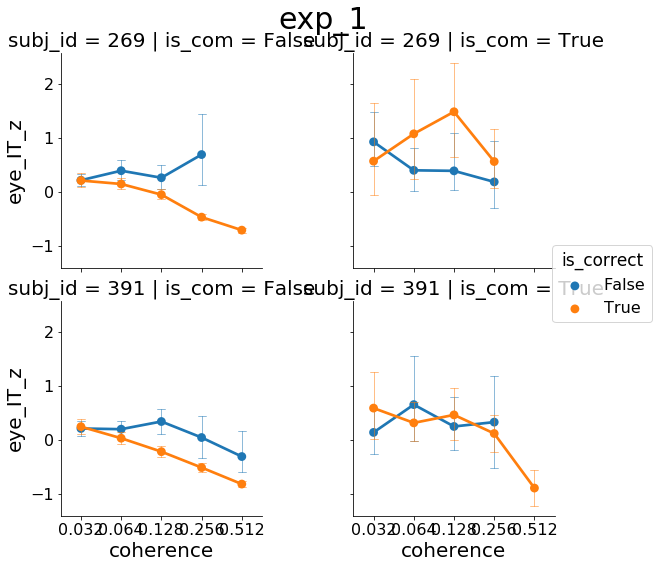

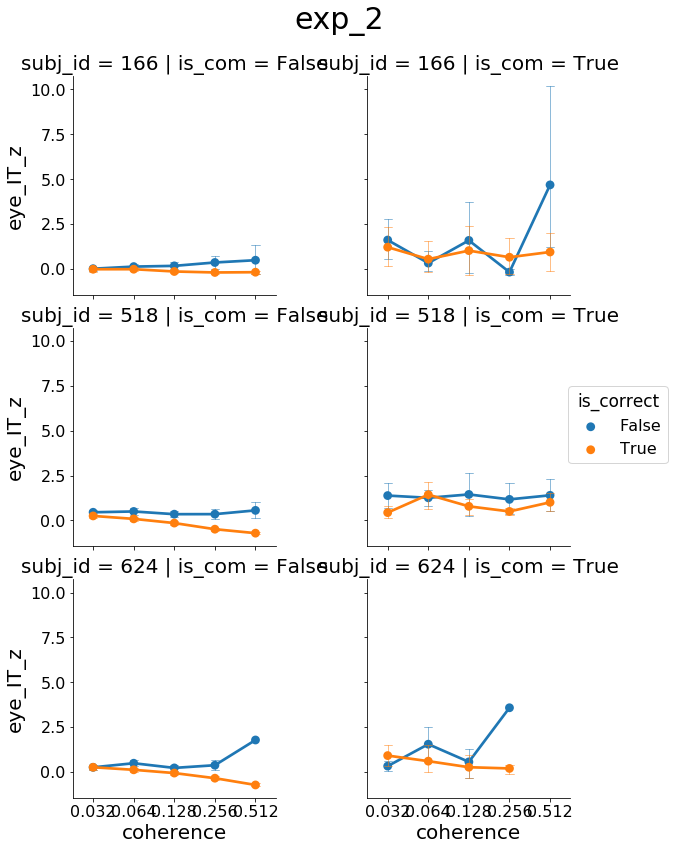

In [16]:
# run this to see same plots for each participant (beware there is little data in each condition then)
plot_var_grid_individual(choices_1[(choices_1.subj_id == 269) | (choices_1.subj_id == 391)], exp_1, 
                         var='eye_IT_z', col='is_com', hue='is_correct')
plot_var_grid_individual(choices_2, exp_2, var='eye_IT_z', col='is_com', hue='is_correct')

<a name="eye_IT_CoM"></a>
## Initiation time in CoM vs non-CoM trials

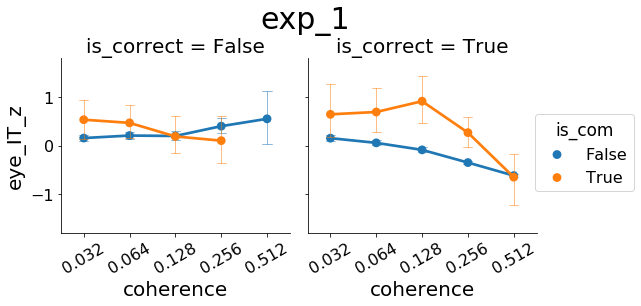

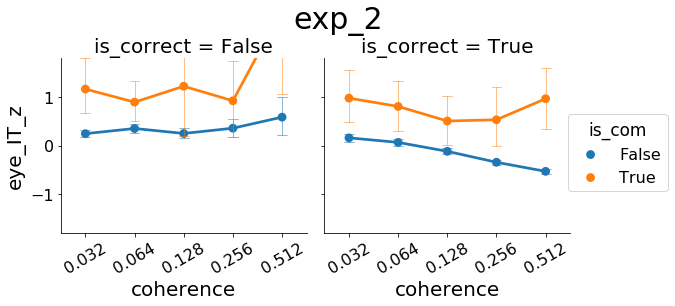

In [17]:
plot_var_grid(choices_1, exp_1, var='eye_IT_z', col='is_correct', hue='is_com')
plot_var_grid(choices_2, exp_2, var='eye_IT_z', col='is_correct', hue='is_com')

The effect of longer IT in CoM trials is much more pronounced in eye movements, and shows up in both experiments. In Exp 2, it is kinda there even for error trials.

<a name="ID_lag"></a>
# Hand-eye lag at initial decision
Now, let's look at the hand-eye lag at initial decision:
>ID_lag = mouse_IT - eye_IT

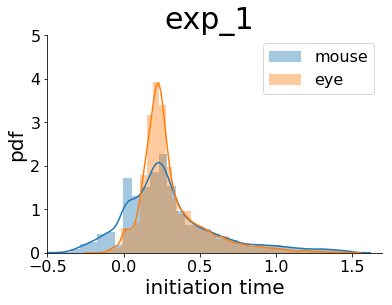

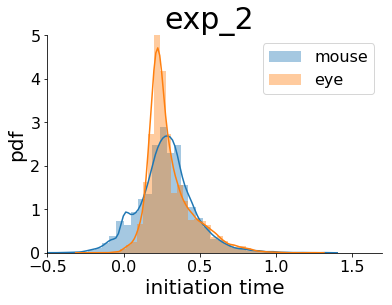

In [18]:
def plot_IT_dist(choices, exp):
    plt.figure()
    ax = sns.distplot(choices.mouse_IT, bins=40, label='mouse')
    sns.distplot(choices[~choices.eye_IT.isnull()].eye_IT, bins=40, label='eye', ax=ax)
    ax.set_xlabel('initiation time')
    ax.set_ylabel('pdf')
    ax.set_xlim(-0.5, 1.7)
    ax.set_ylim(0, 5)
    plt.suptitle(exp, fontsize=30)
    plt.legend()
    plt.savefig('figures/IT_dist_%s' % (exp), bbox_inches='tight')

plot_IT_dist(choices_1, exp_1)
plot_IT_dist(choices_2, exp_2)

Interestingly, ID lag is highly correlated with mouse IT but not with eye IT in Exp 1, so the lag is mainly determined by mouse response. However, in Exp 2, the lag depends on eye IT as well: correlation between the lag and mouse_IT is much weaker in Exp 2.

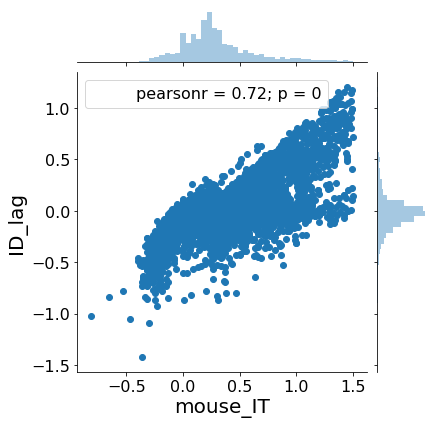

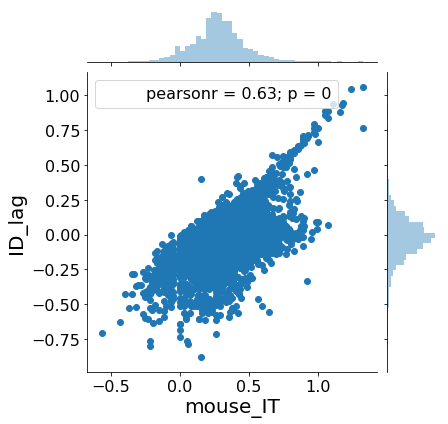

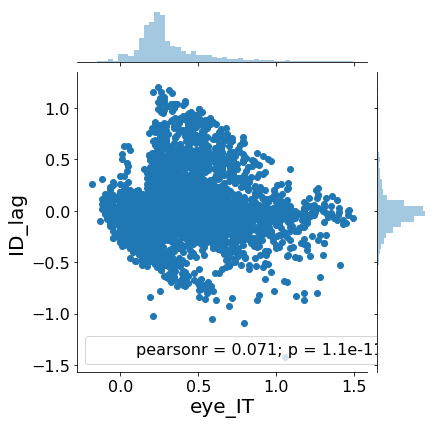

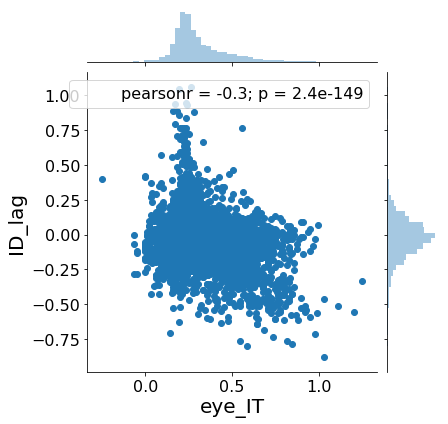

In [19]:
sns.jointplot(data=choices_1[~(choices_1.eye_IT.isnull())], x='mouse_IT', y='ID_lag')
sns.jointplot(data=choices_2[~(choices_2.eye_IT.isnull())], x='mouse_IT', y='ID_lag')
sns.jointplot(data=choices_1[~(choices_1.eye_IT.isnull())], x='eye_IT', y='ID_lag')
sns.jointplot(data=choices_2[~(choices_2.eye_IT.isnull())], x='eye_IT', y='ID_lag')

In Exp 1, dependence of ID lag on coherence basically follows that of mouse IT, with the green participant having substantially larger lag than the others due to late mouse movements.

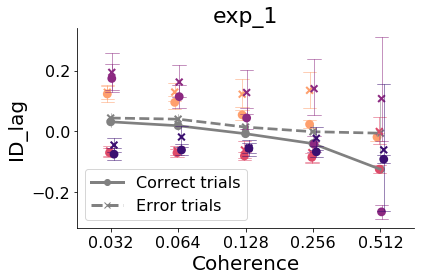

In [20]:
plot_var_vs_coherence(choices_1, exp_1, var='ID_lag', estimator=np.nanmean)

However, if we account for individual differences in scale of the lag, the general pattern becomes very clear

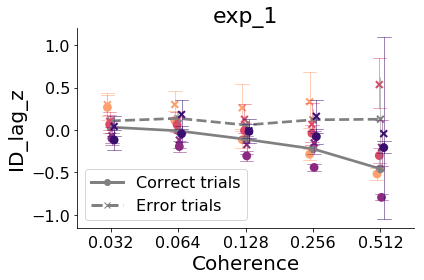

In [21]:
plot_var_vs_coherence(choices_1, exp_1, var='ID_lag_z', estimator=np.nanmean)

Next, let's look at Exp 2 ID lag.

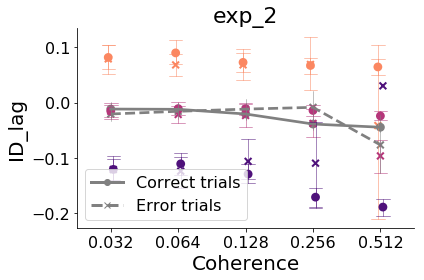

In [22]:
plot_var_vs_coherence(choices_2, exp_2, var='ID_lag', estimator=np.nanmean)

Here the variability is even higher. The three participants have very different lags, one has positive lag, one has negative lag, and another one's lag is around 0. It doesn't become clearer when z-scores are used.

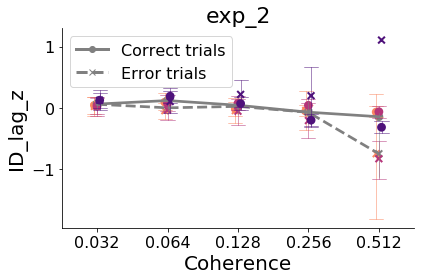

In [23]:
plot_var_vs_coherence(choices_2, exp_2, var='ID_lag_z', estimator=np.nanmean)

<a name="negative"></a>
# Negative initiation times

Premature responses were observed in approx. 10% trials in Exp 1, and more than twice less often in Exp 2.

In [24]:
def print_neg_IT_proportion(choices):
    print(len(choices[(choices.mouse_IT<0)])/len(choices))

print_neg_IT_proportion(choices_1)
print_neg_IT_proportion(choices_2)

0.09514986376021799
0.04075190127708423


However, the rate of premature responses among CoM trials is much lower

In [25]:
print_neg_IT_proportion(choices_1[choices_1.is_com])
print_neg_IT_proportion(choices_2[choices_2.is_com])

0.02
0.02252252252252252


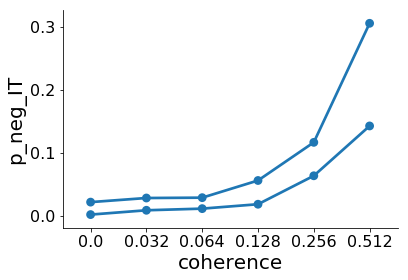

In [26]:
def get_p_neg_IT(choices):
    return (choices.groupby(by=['coherence']).apply(lambda c: len(c[c.mouse_IT<0])/len(c)).rename('p_neg_IT').reset_index())
    
fig = plt.figure()
ax = fig.add_subplot(111)
sns.pointplot(data=get_p_neg_IT(choices_1), x='coherence', y='p_neg_IT', ci=None, ax=ax)
sns.pointplot(data=get_p_neg_IT(choices_2), x='coherence', y='p_neg_IT', ci=None, ax=ax)